In [1]:
import os, glob
from copy import deepcopy

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize as Normalizer
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.visualization import simple_norm

import pandas as pd

from astropy.nddata import CCDData
from astropy.wcs import WCS
from photutils.aperture import SkyCircularAperture, CircularAperture, aperture_photometry
from photutils.segmentation import detect_sources, make_2dgaussian_kernel
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import vstack
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.stats import sigma_clipped_stats
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Tophat2DKernel as Kernel

import ccdproc

from util import *

norm_kwargs = { # these are all from playing around in ds9
    "Harris-B" : dict(vmin=775, vmax=930),
    "Harris-R" : dict(vmin=1175, vmax=1787),
    "Harris-V" : dict(vmin=1140, vmax=1532),
    "Bessell-U" : dict(vmin=186, vmax=252)
}


# Extract the Signal

In [2]:
data_path = os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "calib")
overwrite = False

if overwrite:
    wcs_data_path = os.path.join(data_path, "*WCS*")
    wcs_data_files = glob.glob(wcs_data_path)
    wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]

    print("Done reading in data, starting to clean the chip gap...")

    fig = plt.figure()
    for ii, d in enumerate(wcs_data):

        print(f'Working on {d.meta["FILTER"]}')
        # smooth over the chip gap because it's annoying
        kernel = Kernel(50)
        wcs_data[ii].data = interpolate_replace_nans(d.data, kernel)

        # plot all the images to make sure the chip gap looks okay
        img = wcs_data[ii]
        wcs = img.wcs
        ax = fig.add_subplot(2,2,ii+1) 

        ax.imshow(
            img.data,
            origin="lower",
            norm=simple_norm(
                data=img.data,
                stretch="linear",
                **norm_kwargs[img.meta["FILTER"]]
            ),
            cmap="gray"
        )

        wcs_data[ii].write(wcs_data_files[ii].replace(".fits", ".NOCHIPGAP.fits"))
        
else:
    # we can just read in the ones previously computed, cause this takes a while
    wcs_data_path = os.path.join(data_path, "*WCS.NOCHIPGAP.fits")
    wcs_data_files = glob.glob(wcs_data_path)
    wcs_data = [CustomCCDData.read(f) for f in wcs_data_files]


In [3]:
pos = SkyCoord(
    "05:26:38.320",
    "-17:54:54.68",
    unit=("hourangle", "deg")
)

aperture = SkyCircularAperture(pos, r=5. * u.arcsec)
apertures = [aperture.to_pixel(d.wcs) for d in wcs_data]
kuiper = Kuiper(apertures[0].r)
res = {v[0].meta["FILTER"]: aperture_photometry(*v) for v in zip(wcs_data, apertures)}

res

{'Harris-V': <QTable length=1>
   id       xcenter           ycenter         aperture_sum  
              pix               pix               adu       
 int64      float64           float64           float64     
 ----- ----------------- ----------------- -----------------
     1 686.6747350069558 707.9193545467556 524919.9014615873,
 'Bessell-U': <QTable length=1>
   id       xcenter           ycenter        aperture_sum  
              pix               pix              adu       
 int64      float64           float64          float64     
 ----- ----------------- ----------------- ----------------
     1 691.2074200169961 709.6860327014286 95106.6460402802,
 'Harris-B': <QTable length=1>
   id       xcenter           ycenter         aperture_sum   
              pix               pix               adu        
 int64      float64           float64           float64      
 ----- ----------------- ----------------- ------------------
     1 692.4297288520879 704.3353420770002 352200.8

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>
<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (81.65967196, -17.91519399)>


Text(0.5, 0.01, 'Right Ascension')

/home/nfranz/.local/lib/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  func(*args, **kwargs)


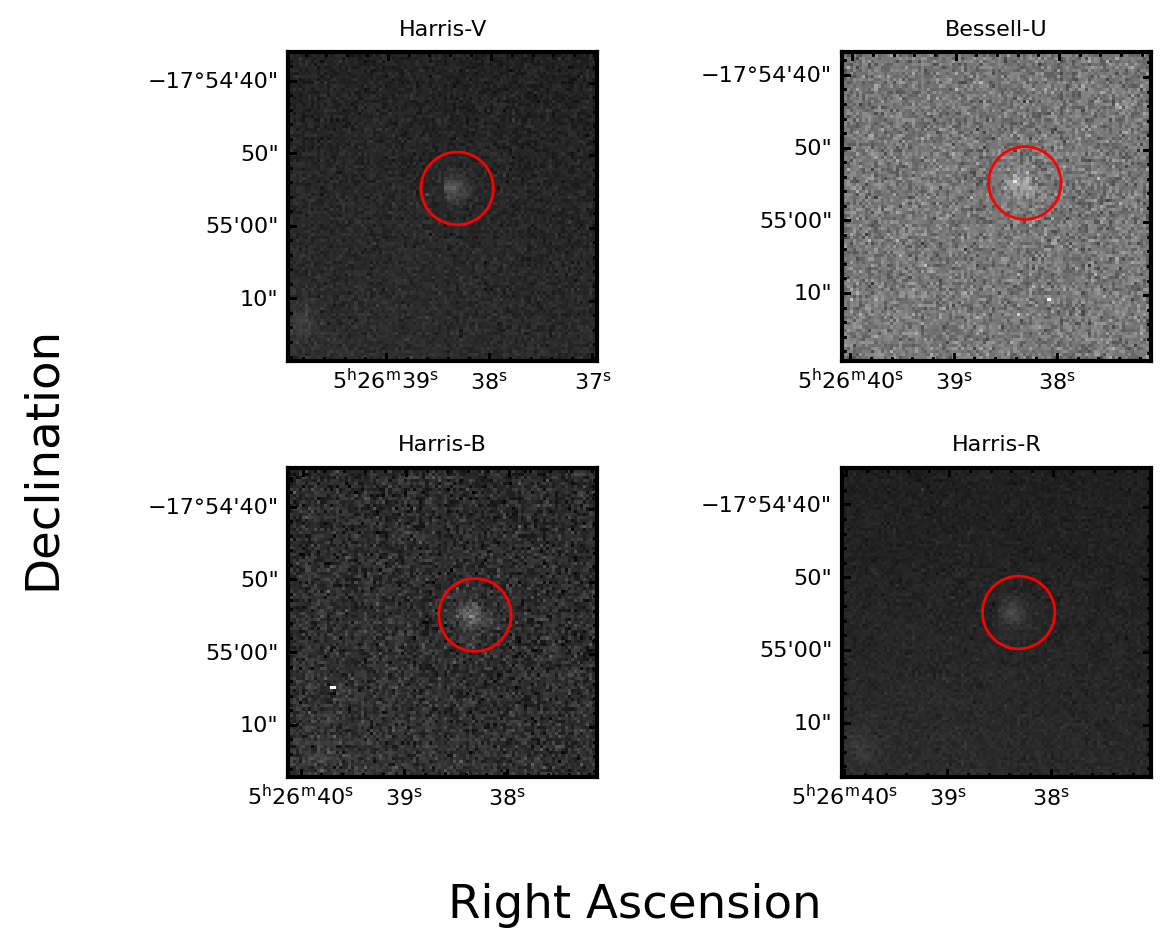

In [4]:
fs = 8
ms = 500
fig = plt.figure()

for ii, (img, a) in enumerate(zip(wcs_data, apertures)):

    wcs = img.wcs
    ax = fig.add_subplot(2,2,ii+1,projection=wcs) 
    
    aper = a.to_sky(wcs)
    print(aper.positions)
    
    circ = SphericalCircle(aper.positions, aper.r, edgecolor='red', facecolor='none', transform=ax.get_transform('fk5'))
    ax.add_patch(circ)
    
    ax.imshow(
        img.data,
        origin="lower",
        norm=simple_norm(
            data=img.data,
            stretch="linear",
            **norm_kwargs[img.meta["FILTER"]]
        ),
        cmap="gray"
    )
    
    for coord in ax.coords._coords:
        coord.set_auto_axislabel(False)
        coord.tick_params(labelsize=fs)
    
    # ax.scatter_coord(pos, ms, edgecolor='r', facecolor="none")
    
    ax.set_title(img.meta["FILTER"], fontsize=fs)
    
    dx = dy = 50
    midx = img.data.shape[0]//2
    midy = img.data.shape[0]//2 + 20
    xlim = (midx-dx, midx+dx)
    ylim = (midy-dy, midy+dy)
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    
fig.supylabel("Declination")
fig.supxlabel("Right Ascension")

In [5]:
res_to_stack = []
for k, row in res.items():
    row["FILTER"] = k
    row["aperture_sum_e"] = row["aperture_sum"] * kuiper.gain
    row["aperture_sum_photons"] = row["aperture_sum_e"] * kuiper.electron_to_photons
    
    res_to_stack.append(row)
    
data = vstack(res_to_stack).to_pandas()
data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons
0,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,2.710008e+06
1,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,4.910079e+05
2,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.818310e+06
3,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,2.863572e+06


# Sky Background Noise

Put a bunch of apertures on the background of the images and median them

In [6]:
from astropy.stats import SigmaClip
from photutils.background import LocalBackground, SExtractorBackground

all_bckgd = dict(
    FILTER = [],
    bckgd_adu = [],
    bckgd_err_adu = []
)

aperture = SkyCircularAperture(pos, r=5. * u.arcsec)

for img in wcs_data:
    bkg = LocalBackground(
        inner_radius=kuiper.aperture_radius,
        outer_radius=2*kuiper.aperture_radius,
        bkg_estimator=SExtractorBackground(SigmaClip(sigma=3))
    )

    aper = aperture.to_pixel(img.wcs)

    bkg_res = bkg(img.data, *aper.positions)*kuiper.npix
    
    all_bckgd["FILTER"].append(img.header["FILTER"])
    all_bckgd["bckgd_adu"].append(bkg_res)
    all_bckgd["bckgd_err_adu"].append(np.sqrt(bkg_res))

bckgd_df = pd.DataFrame(all_bckgd)
bckgd_df["bckgd_e"] = bckgd_df.bckgd_adu*kuiper.gain
bckgd_df["bckgd_err_e"] = bckgd_df.bckgd_err_adu*kuiper.gain
bckgd_df["bckgd_photons"] = bckgd_df.bckgd_e*kuiper.electron_to_photons
bckgd_df["bckgd_err_photons"] = bckgd_df.bckgd_err_e*kuiper.electron_to_photons

data = pd.merge(data, bckgd_df, on="FILTER")

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons
0,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,2.710008e+06,521415.726500,722.091218,1.616389e+06,2238.482774,2.691917e+06,3727.946532
1,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,4.910079e+05,94335.409080,307.140699,2.924398e+05,952.136167,4.870262e+05,1585.677926
2,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.818310e+06,348722.306626,590.527143,1.081039e+06,1830.634143,1.800352e+06,3048.719554
3,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,2.863572e+06,548936.777336,740.902677,1.701704e+06,2296.798300,2.834001e+06,3825.064617


# Background Subtraction

Now, we need to subtract the background from the signal (ie. the aperture sum) in both e and photons. This is so we can get a SNR estimate from the electrons aperture sum and then, finally, convert the aperture sum in photons to usable units.

In [7]:
data["signal_e"] = data.aperture_sum_e - data.bckgd_e
data["signal_photons"] = data.aperture_sum_photons - data.bckgd_photons

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,signal_e,signal_photons
0,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,2.710008e+06,521415.726500,722.091218,1.616389e+06,2238.482774,2.691917e+06,3727.946532,10862.942380,18091.034175
1,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,4.910079e+05,94335.409080,307.140699,2.924398e+05,952.136167,4.870262e+05,1585.677926,2390.834577,3981.671680
2,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.818310e+06,348722.306626,590.527143,1.081039e+06,1830.634143,1.800352e+06,3048.719554,10783.416835,17958.593138
3,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,2.863572e+06,548936.777336,740.902677,1.701704e+06,2296.798300,2.834001e+06,3825.064617,17756.584530,29571.635963


# Dark Noise

Estimate the dark noise by reading in the darks and then summing all of the values in them

In [8]:
dark_combined = CustomCCDData.read(
    os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "COMBINED_DARKS_FIFTY.fits")
)

dark_noise_adu = np.nanstd(dark_combined.data)

data["dark_noise_adu"] = dark_noise_adu
data["dark_noise_e"] = kuiper.gain*dark_noise_adu

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,signal_e,signal_photons,dark_noise_adu,dark_noise_e
0,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,2.710008e+06,521415.726500,722.091218,1.616389e+06,2238.482774,2.691917e+06,3727.946532,10862.942380,18091.034175,22.669084,70.274159
1,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,4.910079e+05,94335.409080,307.140699,2.924398e+05,952.136167,4.870262e+05,1585.677926,2390.834577,3981.671680,22.669084,70.274159
2,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.818310e+06,348722.306626,590.527143,1.081039e+06,1830.634143,1.800352e+06,3048.719554,10783.416835,17958.593138,22.669084,70.274159
3,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,2.863572e+06,548936.777336,740.902677,1.701704e+06,2296.798300,2.834001e+06,3825.064617,17756.584530,29571.635963,22.669084,70.274159


# Read Noise

Estimate the read noise from the bias images

In [9]:
bias_combined = CustomCCDData.read(
    os.path.join(os.environ["HOME"], "instrumentation_project", "my-data", "COMBINED_BIAS.fits")
)

files = ReductionFiles(os.path.join(os.environ["HOME"], "instrumentation_project", "my-data"))
files.read_and_organize("AT2024wsd")
bias_data = [CustomCCDData.read(bias_file) for bias_file in files.bias_files["none"]]

rn = []
for _ in range(100):
    rng_choice = np.random.choice(len(bias_data))
    read_noise = ccdproc.subtract_bias(bias_combined, bias_data[rng_choice])    
    rn.append(read_noise)
    
read_noise_adu = np.nanstd(rn)

data["read_noise_adu"] = read_noise_adu
data["read_noise_e"] = kuiper.gain * read_noise_adu

data

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,bckgd_err_e,bckgd_photons,bckgd_err_photons,signal_e,signal_photons,dark_noise_adu,dark_noise_e,read_noise_adu,read_noise_e
0,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,2.710008e+06,521415.726500,722.091218,1.616389e+06,2238.482774,2.691917e+06,3727.946532,10862.942380,18091.034175,22.669084,70.274159,3.02812,9.387171
1,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,4.910079e+05,94335.409080,307.140699,2.924398e+05,952.136167,4.870262e+05,1585.677926,2390.834577,3981.671680,22.669084,70.274159,3.02812,9.387171
2,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.818310e+06,348722.306626,590.527143,1.081039e+06,1830.634143,1.800352e+06,3048.719554,10783.416835,17958.593138,22.669084,70.274159,3.02812,9.387171
3,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,2.863572e+06,548936.777336,740.902677,1.701704e+06,2296.798300,2.834001e+06,3825.064617,17756.584530,29571.635963,22.669084,70.274159,3.02812,9.387171


# Computing the Signal to Noise Ratio

In [10]:
data.signal_e / data.bckgd_err_e

0    4.852815
1    2.511022
2    5.890536
3    7.731016
dtype: float64

In [11]:
data["noise"] = np.sqrt(data.signal_e + data.bckgd_e + kuiper.npix*(data.read_noise_e**2 + data.dark_noise_e**2))
data["SNR"] = data.signal_e / data.noise

data[["FILTER", "SNR"]]

,FILTER,SNR
0,Harris-V,5.564841
1,Bessell-U,1.518750
2,Harris-B,5.958565
3,Harris-R,8.988200


# Converting to physical units (Zero Point Calibration)

Now that we have the data background subtracted and SNR computed, we need to convert from photons to physical units. I do this by finding another star in the field and computing a ratio of photons to magnitudes

,id,xcenter,ycenter,aperture_sum,FILTER,aperture_sum_e,aperture_sum_photons,bckgd_adu,bckgd_err_adu,bckgd_e,...,signal_photons,dark_noise_adu,dark_noise_e,read_noise_adu,read_noise_e,noise,SNR,zero_point,mag,mag_err
0,1,686.674735,707.919355,524919.901462,Harris-V,1.627252e+06,2.710008e+06,521415.726500,722.091218,1.616389e+06,...,18091.034175,22.669084,70.274159,3.02812,9.387171,1952.066979,5.564841,4.709496e+11,18.538778,3.331412
1,1,691.207420,709.686033,95106.646040,Bessell-U,2.948306e+05,4.910079e+05,94335.409080,307.140699,2.924398e+05,...,3981.671680,22.669084,70.274159,3.02812,9.387171,1574.212310,1.518750,5.001514e+10,17.747590,11.685658
2,1,692.429729,704.335342,352200.828186,Harris-B,1.091823e+06,1.818310e+06,348722.306626,590.527143,1.081039e+06,...,17958.593138,22.669084,70.274159,3.02812,9.387171,1809.733782,5.958565,3.312906e+11,18.164842,3.048526
3,1,689.190232,705.135714,554664.707830,Harris-R,1.719461e+06,2.863572e+06,548936.777336,740.902677,1.701704e+06,...,29571.635963,22.669084,70.274159,3.02812,9.387171,1975.544074,8.988200,4.448183e+11,17.943268,1.996314


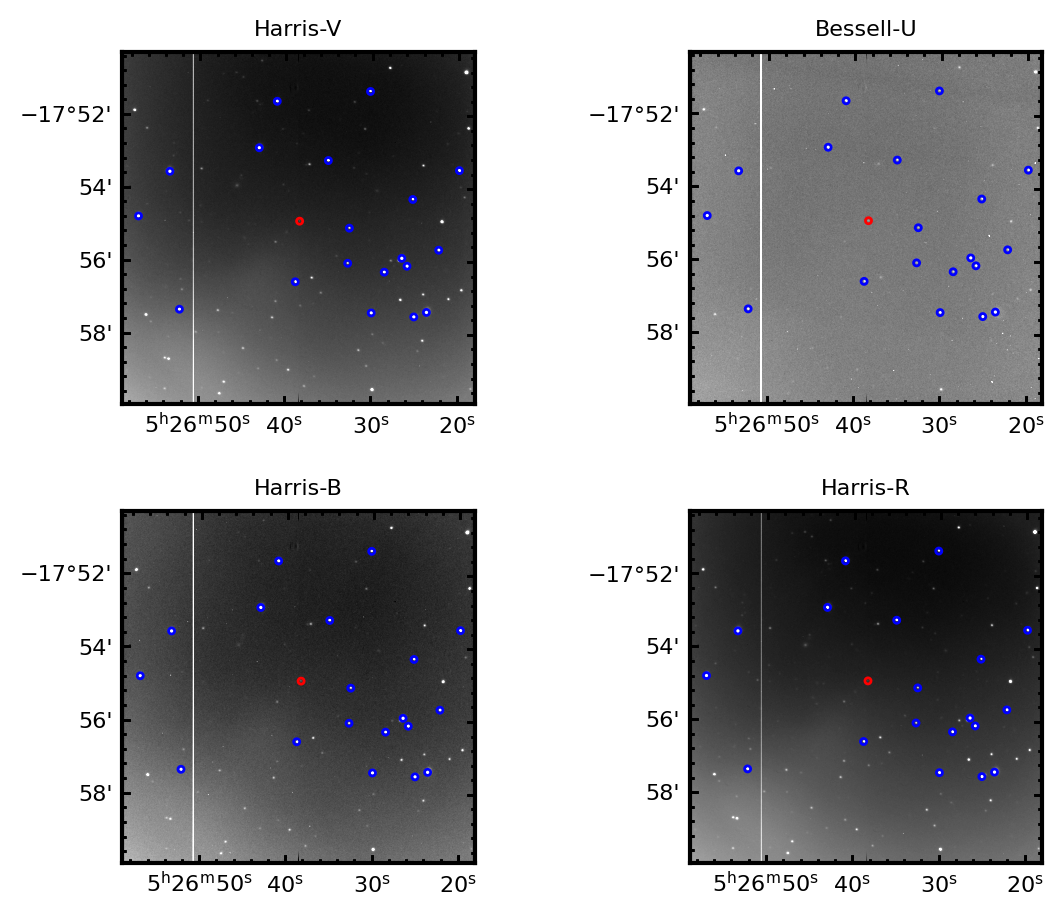

In [12]:
from astroquery.vizier import Vizier

# this information comes from drawing a circle over most of the image in DS9
center = SkyCoord(
    "5:26:38.2737",
    "-17:55:03.793",
    unit=("hour", "deg")
)

radius = "282 arcsec"

# now use it to query Vizier
vizier = Vizier(columns=["Source", "RA_ICRS", "DE_ICRS", "Bmag", "Rmag", "Vmag", "Umag"])
res = vizier.query_region(center, radius=radius, catalog="I/360/syntphot")[0].to_pandas()
res = res.dropna()

fig = plt.figure()
derived_zero_points = {}
radius = 5*u.arcsec

filt_key_map = {
    "Harris-V" : "Vmag",
    "Harris-R" : "Rmag",
    "Harris-B" : "Bmag",
    "Bessell-U": "Umag"
}

for ii, (img, a) in enumerate(zip(wcs_data, apertures)):

    wcs = img.wcs
    mag_key = filt_key_map[img.meta["FILTER"]]
    
    # compute the conversion factor
    # 1) measure the aperture sum for each of the field stars 
    positions = SkyCoord(res.RA_ICRS, res.DE_ICRS, unit="deg", frame="icrs")
    sky_aperture = SkyCircularAperture(positions, radius)
    pix_aperture = sky_aperture.to_pixel(wcs)
    df = aperture_photometry(img, pix_aperture).to_pandas()

    # 2) subtract out the background using an annulus (same method as before)
    bkg = LocalBackground(
        inner_radius=kuiper.aperture_radius,
        outer_radius=2*kuiper.aperture_radius,
        bkg_estimator=SExtractorBackground(SigmaClip(sigma=3))
    )
    df["bkg_sum"] = [bkg(img.data, *a.positions)*kuiper.npix for a in pix_aperture]
    df["signal_adu"] = df.aperture_sum - df.bkg_sum
    
    # 3) convert things appropriately and calculate the conversion factor
    df["aperture_sum_e"] = df.signal_adu * kuiper.gain
    df["aperture_sum_photons"] = df.aperture_sum_e * kuiper.electron_to_photons
    df[mag_key] = list(res[mag_key])
    derived_zero_points[img.meta["FILTER"]] = list(df.aperture_sum_photons*10**(0.4*df[mag_key]))
    
    # plot all of these objects
    ax = fig.add_subplot(2,2,ii+1,projection=wcs) 
    aper = a.to_sky(wcs)
    
    circ = SphericalCircle(aper.positions, aper.r, edgecolor='red', facecolor='none', transform=ax.get_transform('fk5'))
    ax.add_patch(circ)

    for _,row in res.iterrows():
            circ = SphericalCircle(
                SkyCoord(row.RA_ICRS, row.DE_ICRS, unit="deg", frame="icrs"),
                aper.r,
                edgecolor='blue',
                facecolor='none',
                transform=ax.get_transform('fk5')
            )
            ax.add_patch(circ)

    ax.imshow(
        img.data,
        origin="lower",
        norm=simple_norm(
            data=img.data,
            stretch="linear",
            **norm_kwargs[img.meta["FILTER"]]
        ),
        cmap="gray"
    )
    
    for coord in ax.coords._coords:
        coord.set_auto_axislabel(False)
        coord.tick_params(labelsize=fs)
        
    ax.set_title(img.meta["FILTER"], fontsize=fs)

data["zero_point"] = [np.median(derived_zero_points[f]) for f in data.FILTER]
data["mag"] = -2.5*np.log10(data.signal_photons / data.zero_point)

data["mag_err"] = (data.noise*kuiper.electron_to_photons) * (data.mag/data.signal_photons)

data

In [13]:
# save the reduced dataset to a csv
data.to_csv("reduced-photometry.csv")